# 在自己的数据集上训练语义分割模型

同济子豪兄 2023-1-31

## 进入 mmsegmentation 主目录

In [1]:
import os
os.chdir('mmsegmentation')

## 导入工具包

In [2]:
import numpy as np
from PIL import Image

import os.path as osp
from tqdm import tqdm

import mmcv
import mmengine
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'mmcv'

## 数据集下载和预处理

Standord Background 数据集主页：http://dags.stanford.edu/projects/scenedataset.html

该数据集包含 715 张由 [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) 和 [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/) 四个开源数据集中挑选出来的图片。

主要为室外场景，图像尺寸为320x240。

共 8 个类别：

- 天空 sky

- 树 tree

- 道路 road

- 草 grass

- 水 water

- 建筑物 building

- 山 mountain

- 前景物体

- **原版数据集下载及预处理（略）**

In [3]:
# 斯坦福官网原版数据集
# !wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz

# 子豪兄国内镜像
# !wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/iccv09Data.tar.gz -O stanford_background.tar.gz

# 删除旧的数据集文件夹（如有）
# !rm -rf iccv09Data

# 解压
# !tar xf stanford_background.tar.gz

In [4]:
# 数据集图片和标注路径
data_root = 'iccv09Data'
img_dir = 'images'
ann_dir = 'labels'

# 类别和对应的颜色
classes = ('sky', 'tree', 'road', 'grass', 'water', 'bldg', 'mntn', 'fg obj')
palette = [[128, 128, 128], [129, 127, 38], [120, 69, 125], [53, 125, 34], 
           [0, 11, 123], [118, 20, 12], [122, 81, 25], [241, 134, 51]]

# # 转换语义分割标注格式为 segmentation map 图片
# for file in tqdm(mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt')):
#   seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
#   seg_img = Image.fromarray(seg_map).convert('P')
#   seg_img.putpalette(np.array(palette, dtype=np.uint8))
#   seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt', 
#                                                          '.png')))

# 随机划分训练集和验证集
# split_dir = 'splits'
# mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
# filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
#     osp.join(data_root, ann_dir), suffix='.png')]
# with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
#   # select first 4/5 as train set
#   train_length = int(len(filename_list)*4/5)
#   f.writelines(line + '\n' for line in filename_list[:train_length])
# with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
#   # select last 1/5 as train set
#   f.writelines(line + '\n' for line in filename_list[train_length:])

- **直接下载子豪兄预处理好的数据集**

In [7]:
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/iccv09Data.zip


--2023-01-31 10:54:51--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20230130-mmseg/dataset/iccv09Data.zip
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 12116686 (12M) [application/zip]
正在保存至: “iccv09Data.zip”

iccv09Data.zip      100%[===================>]  11.55M  25.3MB/s    用时 0.5s    

2023-01-31 10:54:51 (25.3 MB/s) - 已保存 “iccv09Data.zip” [12116686/12116686])



In [8]:
# 解压
!unzip iccv09Data.zip >> /dev/null

In [9]:
# 删除压缩包
!rm -rf iccv09Data.zip

## 查看数据集中的图片

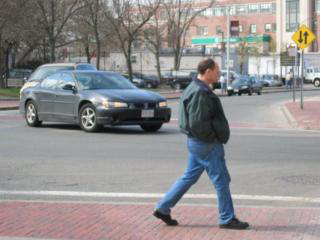

In [10]:
Image.open('iccv09Data/images/6000124.jpg')

## 查看 语义分割标注 Segmentation Map

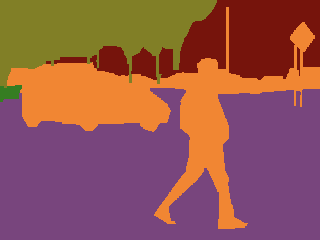

In [11]:
Image.open('iccv09Data/labels/6000124.png')

## 绘制语义分割类别图例

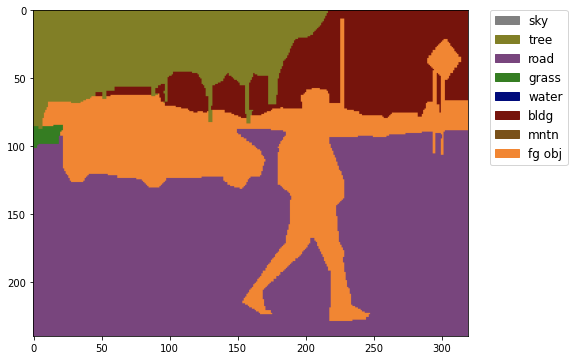

In [12]:
import matplotlib.patches as mpatches
img = Image.open('iccv09Data/labels/6000124.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# 图例小块
patches = [mpatches.Patch(color=np.array(palette[i])/255., label=classes[i]) for i in range(8)]
# 图例
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize='large')
plt.show()

## 修改数据集类

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [13]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', **kwargs)

文档：https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data

## 修改config配置文件

In [14]:
# 下载 config 文件 和 预训练模型checkpoint权重文件
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

processing pspnet_r50-d8_4xb2-40k_cityscapes-512x1024...
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth exists in /home/featurize/work/MMSegmentation教程/mmsegmentation
Successfully dumped pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py to /home/featurize/work/MMSegmentation教程/mmsegmentation


In [15]:
from mmengine import Config
cfg = Config.fromfile('configs/pspnet/pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')

In [16]:
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.crop_size = (256, 256)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 8
cfg.model.auxiliary_head.num_classes = 8

# 修改数据集的 type 和 root
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# 载入预训练模型权重
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# 工作目录
cfg.work_dir = './work_dirs/tutorial'

# 训练迭代次数
cfg.train_cfg.max_iters = 800
# 评估模型间隔
cfg.train_cfg.val_interval = 400
# 日志记录间隔
cfg.default_hooks.logger.interval = 100
# 模型权重保存间隔
cfg.default_hooks.checkpoint.interval = 400

# 随机数种子
cfg['randomness'] = dict(seed=0)

## 查看完整config配置文件

In [17]:
print(cfg.pretty_text)

norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 1024))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(256, 256)),
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels

## 准备训练

In [18]:
from mmengine.runner import Runner
from mmseg.utils import register_all_modules

# register all modules in mmseg into the registries
# do not init the default scope here because it will be init in the runner
register_all_modules(init_default_scope=False)
runner = Runner.from_cfg(cfg)

01/31 10:55:21 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.7.10 (default, Jun  4 2021, 14:48:32) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA RTX A4000
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.2, V11.2.152
    GCC: gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
    PyTorch: 1.10.1+cu113
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.3
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-genco

/home/featurize/work/MMSegmentation教程/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/featurize/work/MMSegmentation教程/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/featurize/work/MMSegmentation教程/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:236: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  'Default ``avg_non_ignore`` is False, if you would like to '


01/31 10:55:29 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
01/31 10:55:29 - mmengine - WARNING - The "hook" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
01/31 10:55:30 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook  

/home/featurize/work/MMSegmentation教程/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


## 开始训练

如果遇到报错`CUDA out of memeory`，重启实例或使用显存更高的实例即可。

In [19]:
runner.train()

01/31 10:55:34 - mmengine - WARNING - The "loop" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
01/31 10:55:34 - mmengine - WARNING - The "dataset" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
01/31 10:55:34 - mmengine - WARNING - The "transform" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
01/31 10:55:34 - mmengine - WARNING - The "data sampler" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
01/31 10:55:34 - mmengine - WARNING - The "optimizer wrapper constructor" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
01/31 10:55:34 - mmengine - WARNING - The "optimizer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
01/31 10:55:

/environment/miniconda3/lib/python3.7/site-packages/mmengine/evaluator/metric.py:47: UserWarning: The prefix is not set in metric class IoUMetric.
  warnings.warn('The prefix is not set in metric class '


01/31 10:55:35 - mmengine - WARNING - The "weight initializer" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
01/31 10:55:35 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
01/31 10:55:35 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c


Downloading: "https://download.openmmlab.com/pretrain/third_party/resnet50_v1c-2cccc1ad.pth" to /home/featurize/.cache/torch/hub/checkpoints/resnet50_v1c-2cccc1ad.pth


01/31 10:55:37 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([8]).
01/31 10:55:37 - mm

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

## 使用训练得到的模型预测图像

In [20]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

In [22]:
# 初始化模型
checkpoint_path = './work_dirs/tutorial/iter_800.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

Loads checkpoint by local backend from path: ./work_dirs/tutorial/iter_800.pth


In [23]:
# 载入测试图像
img = mmcv.imread('iccv09Data/images/6000124.jpg')
# img = mmcv.imread('iccv09Data/images/6000295.jpg')

In [24]:
# 预测
result = inference_model(model, img)

/environment/miniconda3/lib/python3.7/site-packages/mmengine/visualization/visualizer.py:163: UserWarning: `Visualizer` backend is not initialized because save_dir is None.
  warnings.warn('`Visualizer` backend is not initialized '


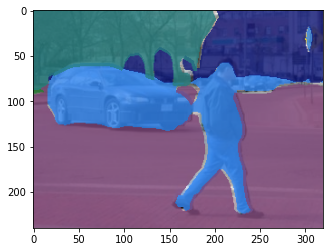

In [25]:
# 可视化预测结果
visualization = show_result_pyplot(model, img, result, opacity=0.8, title='MMSeg', out_file='outputs/C.jpg')
plt.imshow(mmcv.bgr2rgb(visualization))
plt.show()

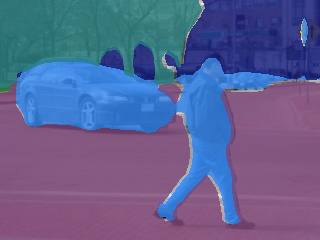

In [26]:
Image.open('outputs/C.jpg')